# Web attack detection using CNN-BiLSTM neural net and CICIDS2017 dataset

In this notebook we implement web attack detection using CNN-BiLSTM neural net and CICIDS2017 dataset, and compare this neural net performance to our previously developed Random Forest model (https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/web-attack-detection.ipynb).

Training data: https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/web_attacks_balanced.zip

Training dataset is the balanced dataset based on CICIDS2017: https://www.unb.ca/cic/datasets/ids-2017.html
    
Sources:
- https://paperswithcode.com/paper/efficient-deep-cnn-bilstm-model-for-network
- Jay Sinha and M. Manollas. 2020. Efficient Deep CNN-BiLSTM Model for Network Intrusion Detection. In Proceedings of the 2020 3rd International Conference on Artificial Intelligence and Pattern Recognition (AIPR 2020). Association for Computing Machinery, New York, NY, USA, 223–231. DOI:https://doi.org/10.1145/3430199.3430224.
- https://github.com/razor08/Efficient-CNN-BiLSTM-for-Network-IDS/blob/master/NSL_KDD_Final.ipynb
    

## Data preprocessing

In [1]:
from itertools import cycle
import pickle
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interp
from scipy.stats import zscore
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn.preprocessing
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Convolution1D, MaxPooling1D, Reshape, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import get_file, plot_model

%matplotlib inline

Download the dataset from Github to Google Colab and unzip it.

In [ ]:
!wget https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/datasets/web_attacks_balanced.zip?raw=true -O dataset.zip
!unzip -u dataset.zip

Load our dataset and separate it into feature vectors and labels.

In [2]:
data = pd.read_csv('web_attacks_balanced.csv', delimiter=',')

y = data['Label']
X = data.drop('Label', axis=1)

### Preparing feature vectors for training

First, we need to inspect feature vectors.

In [3]:
X

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,60778,1261,39649.0,1599,53.0,17.0,181,204.0,2.0,2.0,...,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,59519,1261,27081.0,1599,53.0,17.0,181,209.0,2.0,2.0,...,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,59636,1261,28078.0,1599,53.0,17.0,181,23891.0,2.0,2.0,...,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,69545,1265,2500.0,1599,53.0,17.0,181,205.0,2.0,2.0,...,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,34999,1256,36656.0,1599,53.0,17.0,181,155.0,2.0,2.0,...,1.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,30455,1749,443.0,1596,35898.0,6.0,132,56.0,1.0,1.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7263,29860,488,443.0,1596,53466.0,6.0,132,59.0,1.0,1.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7264,10232,1001,443.0,1596,58663.0,6.0,132,84.0,1.0,1.0,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7265,29811,461,443.0,1596,36058.0,6.0,132,86.0,1.0,1.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check the absence of missing values in feature vectors.

In [4]:
X.isnull().values.any()

False

As we can see, the range of features is not normalized. We need to perform feature scaling for the correct functioning of selected deep learning algorithms (CNN and BiLSTM).

In our case, the min-max normalization is used: all selected features are transformed into the range [0,1].

In [5]:
scaler = sklearn.preprocessing.MinMaxScaler()

To prevent data leakage, feature scaling would be performed on cross-validation folds at the training step.

### Preparing labels for training

First, we need to inspect labels.

In [6]:
y

0       BENIGN
1       BENIGN
2       BENIGN
3       BENIGN
4       BENIGN
         ...  
7262    BENIGN
7263    BENIGN
7264    BENIGN
7265    BENIGN
7266    BENIGN
Name: Label, Length: 7267, dtype: object

Check the absence of missing values in labels.

In [7]:
y.isnull().values.any()

False

As we can see, labels are categorical. We would need to transform them into the numeric form before the neural network training. In order to achieve that, we would apply one-hot encoding to labels.

To prevent data leakage, one-hot encoding would be performed within cross-validation folds at the training step.

## The neural network preparation

Define and compile the neural network.
<p> We use a sequential model with CNN and BiLSTM layers, and batch normalization is applied before BiLSTM layers. A dropout layer is put before the final layer to prevent overfitting.
<p> Categorical crossentropy is chosen as a loss function because of the multiclass classification. To get the classification result, the softmax activation function is applied to the output of the last, fully connected layer. 

In [8]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=122, padding="same",
          activation="relu", input_shape=(83, 1)))
model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Reshape((128, 1), input_shape=(128, )))

model.add(MaxPooling1D(pool_size=(5)))
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(128, return_sequences=False)))

model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 83, 64)            7872      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 64)            256       
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
reshape (Reshape)            (None, 128, 1)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 25, 1)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 1)             4

## The neural network training

We use Stratified K-Folds cross-validation in our experiment.

In [10]:
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

Accuracy classification score is stored for each fold.

In [11]:
accuracy_per_fold = []

The training step is designed for the use with different versions of Tensorlow, if necessary. It is also possible to choose whether the training should be performed by CPU or GPU.

Note that data preprocessing is largely performed at this step to prevent data leakage.

This step may take a long time, 4 minutes or more depending on the CPU performance (it will be faster with GPU).

In [12]:
# Tensorflow 1.14.

# This option may be used to speed up the CPU computation in some cases.
# import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_cpu_global_jit'

# Configure session parameters for the optimal parallelization and choose the computational device (CPU, GPU or both).
# config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=48,
#                                   inter_op_parallelism_threads=48, allow_soft_placement=True, device_count={'CPU': 24})
# with tf.compat.v1.Session(config=config) as sess:

# Tensorflow 2.X, the computation is performed on CPU.
with tf.device('/CPU:0'):

# Tensorflow 2.X, the computation is performed on GPU.
# with tf.device('/GPU:0'):
    # Set a timer for the learning time evaluation.
    start_time = time.time()

    # Stratified K-Folds cross-validation.
    for train_index, test_index in cv.split(X, y):
        # Get the test data and the validation data for a current fold.
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        print("Train index:", train_index)
        print("Test index:", test_index)

        # Feature scaling of data.
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

        # We need to reshape feature vectors to use them as the neural network input.
        X_train = np.reshape(
            X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(
            X_test, (X_test.shape[0], X_test.shape[1], 1))

        # One-Hot encoding for labels.
        y_train_encoded = pd.get_dummies(y_train).values
        y_test_encoded = pd.get_dummies(y_test).values

        # Fit the neural net model.
        model.fit(X_train, y_train_encoded, validation_data=(
            X_test, y_test_encoded), epochs=10)

        # Apply the neural net model to the validation data and get the accuracy of this prediction.
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        y_eval = np.argmax(y_test_encoded, axis=1)
        score = metrics.accuracy_score(y_eval, y_pred)
        accuracy_per_fold.append(score)
        print("Validation score: {}".format(score))

    # Get the learning time.
    print('Total operation time: ', time.time() - start_time, 'seconds')

Train index: [   5    6    7 ... 7262 7264 7265]
Test index: [   0    1    2 ... 7258 7263 7266]
Epoch 1/10
114/114 [==============================] - 28s 131ms/step - loss: 0.2454 - accuracy: 0.9268 - val_loss: 0.8616 - val_accuracy: 0.8819
Epoch 2/10
114/114 [==============================] - 12s 108ms/step - loss: 0.0548 - accuracy: 0.9851 - val_loss: 3.1245 - val_accuracy: 0.2094
Epoch 3/10
114/114 [==============================] - 12s 105ms/step - loss: 0.0523 - accuracy: 0.9857 - val_loss: 1.3254 - val_accuracy: 0.4111
Epoch 4/10
114/114 [==============================] - 12s 105ms/step - loss: 0.0307 - accuracy: 0.9920 - val_loss: 0.2037 - val_accuracy: 0.9373
Epoch 5/10
114/114 [==============================] - 12s 107ms/step - loss: 0.0213 - accuracy: 0.9937 - val_loss: 0.0574 - val_accuracy: 0.9697
Epoch 6/10
114/114 [==============================] - 12s 104ms/step - loss: 0.0284 - accuracy: 0.9906 - val_loss: 0.0493 - val_accuracy: 0.9862
Epoch 7/10
114/114 [=============

## Model evaluation

Here we can see accuracy classification score for each fold.

In [13]:
accuracy_per_fold

[0.9854155200880572, 0.993944398568676]

Get evaluation metrics for the final fold of data.

In [14]:
accuracy = metrics.accuracy_score(y_eval, y_pred)
precision = metrics.precision_score(y_eval, y_pred, average='weighted')
recall = metrics.recall_score(y_eval, y_pred, average='weighted')
f1 = metrics.f1_score(y_eval, y_pred, average='weighted')

print('Accuracy =', accuracy)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)

Accuracy = 0.993944398568676
Precision = 0.9946837401088962
Recall = 0.993944398568676
F1 = 0.9942001611628348


Visualize a confusion matrix for the final fold of data to evaluate the classifier's performance.

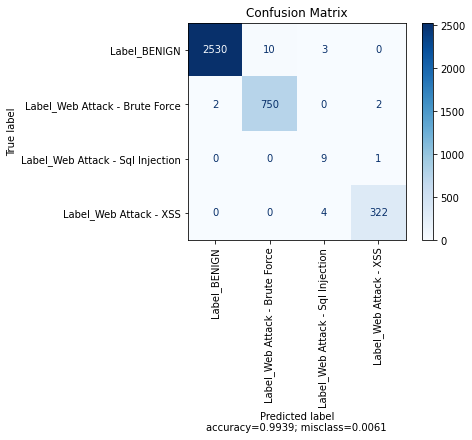

In [15]:
# Get the confusion matrix for the last fold of data.
confusion_matrix = metrics.confusion_matrix(y_eval, y_pred)

# Evaluate accuracy and misclassification scores.
accuracy = np.trace(confusion_matrix) / float(np.sum(confusion_matrix))
misclass = 1 - accuracy

# Plot the confusion matrix.
metrics.ConfusionMatrixDisplay.from_predictions(
    y_eval, y_pred, display_labels=['Label_BENIGN', 'Label_Web Attack - Brute Force',
                                    'Label_Web Attack - Sql Injection', 'Label_Web Attack - XSS'],
    xticks_rotation='vertical', cmap='Blues')
plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(
    accuracy, misclass))
plt.title('Confusion Matrix')
plt.show()

Plot ROC curves for all classes using the last fold of data.

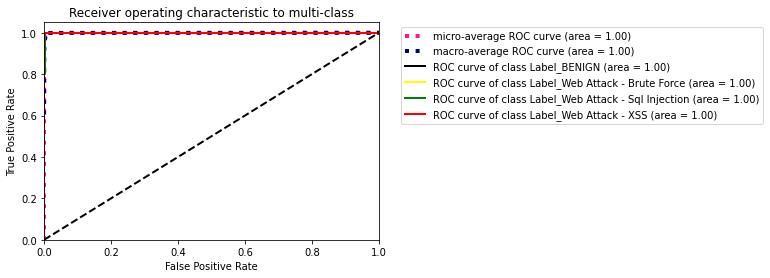

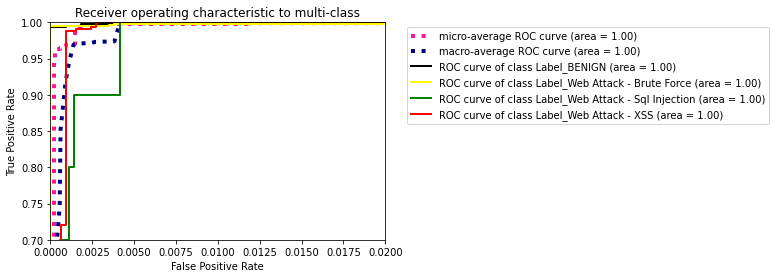

In [16]:
target_class = []
target_class = ['Label_BENIGN', 'Label_Web Attack - Brute Force',
                'Label_Web Attack - Sql Injection', 'Label_Web Attack - XSS']

y_pred = model.predict(X_test)

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class.
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_test_encoded.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area.

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Then interpolate all ROC curves at this points.
mean_tpr = np.zeros_like(all_fpr)
for i in range(4):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC.
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves.
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['black', 'yellow', 'green', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

# Zoom in the plot.
plt.figure(2)
plt.xlim(0, 0.02)
plt.ylim(0.7, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['black', 'yellow', 'green', 'red'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(target_class[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

## Comparison to Random Forest model

Download and open our previously developed model for this dataset: Random Forest (see https://colab.research.google.com/github/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/web-attack-detection.ipynb).

In [ ]:
!wget https://github.com/fisher85/ml-cybersecurity/blob/master/python-web-attack-detection/webattack_detection_rf_model.pkl?raw=true -O webattack_detection_rf_model.pkl

In [17]:
with open('webattack_detection_rf_model.pkl', 'rb') as f:
    rfc = pickle.load(f)
rfc

C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


RandomForestClassifier(max_depth=17, max_features=10, min_samples_leaf=3,
                       n_estimators=50, oob_score=True, random_state=42)